In [1]:
import sys  
sys.path.insert(0, '../script/')

In [2]:
import os
import pandas as pd

from data import TimeSeriesData, timedata
from simple_shap import *

from gru import GRUNet

In [3]:
data_dir = '/home/amansinha/Downloads/data/time-series/Le CAC et ses 7 majors 2021-Aman/'

df = pd.read_csv(data_dir + 'AIR.FR-d-20200701.csv', sep=' ', names=['name', 'date', 'time', 'val', 'extra'])

df.drop('extra', axis=1, inplace=True)

df['datetime'] = df[['date', 'time']].agg(' '.join, axis=1)
df['datetime'] = df['datetime'].astype('datetime64[ns]')

df.drop(['date', 'time'], axis=1, inplace=True)
df

,name,val,datetime
0,AIR.FR-d,63.60,2020-01-07 09:00:00
1,AIR.FR-d,63.62,2020-01-07 09:00:15
2,AIR.FR-d,63.67,2020-01-07 09:00:30
3,AIR.FR-d,63.66,2020-01-07 09:00:45
4,AIR.FR-d,63.57,2020-01-07 09:01:00
...,...,...,...
248997,AIR.FR-d,62.70,2020-10-30 17:29:00
248998,AIR.FR-d,62.70,2020-10-30 17:29:15
248999,AIR.FR-d,62.66,2020-10-30 17:29:30
249000,AIR.FR-d,62.64,2020-10-30 17:29:45


In [4]:
ts = TimeSeriesData(df, name='BNP', h=7, k=4)
ts.prepare_data()
datadf = ts.df
datadf.head()

Size of Dataset: 62243


,feat0,feat1,feat2,feat3,feat4,feat5,feat6,Y0
0,63.60,63.57,63.67,63.70,63.73,63.62,63.55,63.30
1,63.57,63.67,63.70,63.73,63.62,63.55,63.30,63.05
2,63.67,63.70,63.73,63.62,63.55,63.30,63.05,63.14
3,63.70,63.73,63.62,63.55,63.30,63.05,63.14,63.02
4,63.73,63.62,63.55,63.30,63.05,63.14,63.02,63.34


In [299]:
import torch
import random
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [456]:
class GRUEncoder(nn.Module):
    def __init__(self, input_dim,seq_len, hidden_dim,output_dim, n_layer, bidir, dropout=0.2):
        super(GRUEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.bidir = bidir
        self.n_layer = n_layer
        self.seq_len = seq_len
        self.gru = nn.GRU(input_dim, self.hidden_dim, 
                          self.n_layer, batch_first=True, 
                          dropout=dropout)
        
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        #print('gru encoder input', x.shape, h.shape)
        out, h = self.gru(x, h)
        out  = self.fc(self.relu(out))
        return out, h
    
    def init_hidden(self, batch_size):
        wt = next(self.parameters()).data
        hidden = wt.new(self.n_layer, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
    
class GRUAttnDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layer, seq_len, dropout_p=0.1 ):
        super(GRUAttnDecoder, self).__init__()
        self.hidden_size = hidden_dim
        self.output_size = output_dim
        self.n_layer = n_layer
        self.dropout_p = dropout_p
        self.seq_len = seq_len

        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.seq_len)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layer, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        
        #print('***',input.shape, hidden.shape)
        attn_weights = F.softmax(
            self.attn(torch.cat((input[0], hidden[-1]), 1)), dim=1)
        
        #print('atwt:',attn_weights.shape)
        #print('for bmm:', attn_weights.unsqueeze(1).shape, encoder_outputs.shape)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)
        
        #print('att_applied===',attn_applied.shape)
        #print('now_decode',input[0].shape, attn_applied.squeeze().shape)
        
        output = torch.cat((input[0], attn_applied.squeeze()), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        #print('outshape', output.shape, hidden.shape)
        output, hidden = self.gru(output[0].unsqueeze(1), hidden)

        output = self.out(output).squeeze(-1)
        return output, hidden, attn_weights

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layer, batch_size, self.hidden_size, device=device)
    
    
class AttentionWrapper(nn.Module):
    def __init__(self, encoder, decoder, output_dim, batch_size, device=None):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_size = output_dim
        self.batch_size = batch_size
        self.device = torch.device('cpu')
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def evaluate(self):
        self.encoder.eval()
        self.decoder.eval()
        
    def state_dict(self):
        return {'encoder': self.encoder.state_dict(),
               'decoder': self.decoder.state_dict()}
    
    def load_state_dict(self, state_dict):
        self.encoder.load_state_dict(state_dict['encoder'])
        self.decoder.load_state_dict(state_dict['decoder'])
        
    def forward(self, input):
        
        input_seq = input.permute(0, 2, 1)
        #print(input_seq.shape)
        he = self.encoder.init_hidden(input_seq.shape[0])
        hd = self.decoder.init_hidden(input_seq.shape[0])
        
        encoder_outputs,last_hidden = self.encoder(input_seq.to(self.device).float(), he)
        
        dec_output, dec_hidden, dec_att = self.decoder(last_hidden, hd, encoder_outputs)
        
        return dec_output, dec_att

    

In [515]:
device = torch.device('cpu')
def train(trainloader ,params, inpdim,num=None):
    
    input_dim = inpdim
    seq_len = 7
    output_dim = 1
    
    n_layers = 1
    batch_size= 32
    
    encoder = GRUEncoder(input_dim, seq_len=seq_len, hidden_dim=params['hidden_dim'],
                   output_dim=params['hidden_dim'], n_layer=n_layers, bidir=False).to(device)
    decoder = GRUAttnDecoder(hidden_dim=params['hidden_dim'], 
                             output_dim=output_dim, n_layer=n_layers, seq_len=7).to(device)
    
    #print(encoder)
    #print(decoder)
    
    tsatt = AttentionWrapper(encoder, decoder, output_dim, batch_size)

    loss = 0

    criterion = nn.MSELoss()
    enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=params['lr'])
    dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=params['lr'])
    
    if num: writer = SummaryWriter(f'runs/gru_att_experiment_{num}')
    
    tsatt.train()
    
    epoch_times  = []
    p =0
    for epoch in range(params['epochs']):
        start = time.time()
        #he = encoder.init_hidden(batch_size)
        #hd = decoder.init_hidden(batch_size)
        avg_loss = 0
        counter = 0
        
        for x, label in trainloader:
            counter +=1
            p +=1
            #h = he.data
            
            encoder.zero_grad()
            decoder.zero_grad()
            """
            encoder_outputs = torch.zeros(batch_size,x.shape[-1], encoder.hidden_dim, device=device)
            
            last_hidden = 0
            
            #'''
            for ei in range(x.shape[-1]):
                enc_output, enc_hidden = encoder(x[:,:,ei].unsqueeze(dim=-1).to(device).float(), he)
                #print('==>', enc_output.shape, enc_hidden.shape)
                encoder_outputs[ei] = enc_output[0,0]
                last_hidden = enc_hidden
            #print('encoder output:', encoder_outputs.shape)
            #'''
            print('==>', x.shape)
            x = x.permute(0, 2, 1)
            encoder_outputs,last_hidden = encoder(x.to(device).float(), he)
            print('encoder output:', encoder_outputs.shape)
            '''
            
            decoder_hidden = h
            decoder_attentions = torch.zeros(output_dim, output_dim)
            
            
            #for di in range(output_dim):
            dec_output, dec_hidden, dec_att = decoder(last_hidden, hd, encoder_outputs)
            
            print("-----------",dec_output.shape, label.shape, dec_att.shape)
            """
            dec_output, dec_att = tsatt(x)
            
            loss = criterion(dec_output, label.to(device).float())
            loss.backward()
            
            #if counter % 25 == 0: print(dec_output[:10])#,'\n', label[:10])
             
            enc_optimizer.step()
            dec_optimizer.step()
            
            avg_loss += loss.item()
            
            if counter % 20 == 0:
                print(f"Epoch : {epoch}, Step: {counter}/{len(trainloader)} ==> Avg Loss for epoch: {avg_loss/counter}")
                if num: writer.add_scalar('training_loss', avg_loss/counter, p)
        
        current_time = time.time()
        #print(f"Total time elapsed: {current_time-start} seconds")
        epoch_times.append(current_time- start)
    
    print(f"Total Training Time: {sum(epoch_times)} seconds")
    
    return tsatt



def evaluate(model, testdataloader):
    
    model.evaluate()
    outputs = []
    att_wts = []
    targets = []
    
    start = time.time()
    
    for x,y in testdataloader:
        
        #h = model.init_hidden(x.shape[0])
        out, atw = model(x.to(device))
        att_wts.extend(atw.cpu().detach().squeeze())
        outputs.extend(out.cpu().detach().numpy().squeeze())
        targets.extend(y.numpy())
    
    att_wts = torch.stack(att_wts)
        
    return outputs, att_wts
            

In [509]:
params = {'lr': 0.01,
         'hidden_dim':128,
         'epochs': 10,
         }

In [516]:
model = train(traindataloader, params, 1)

/home/amansinha/venv/global_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch : 0, Step: 20/318 ==> Avg Loss for epoch: 2764.6728393554686
Epoch : 0, Step: 40/318 ==> Avg Loss for epoch: 1813.6792274475097
Epoch : 0, Step: 60/318 ==> Avg Loss for epoch: 1260.2549622853596
Epoch : 0, Step: 80/318 ==> Avg Loss for epoch: 948.0978893637657
Epoch : 0, Step: 100/318 ==> Avg Loss for epoch: 758.8879629981518
Epoch : 0, Step: 120/318 ==> Avg Loss for epoch: 632.7250278905034
Epoch : 0, Step: 140/318 ==> Avg Loss for epoch: 542.583175822241
Epoch : 0, Step: 160/318 ==> Avg Loss for epoch: 474.996322420612
Epoch : 0, Step: 180/318 ==> Avg Loss for epoch: 422.434238308337
Epoch : 0, Step: 200/318 ==> Avg Loss for epoch: 380.3968314999342
Epoch : 0, Step: 220/318 ==> Avg Loss for epoch: 345.9967152021148
Epoch : 0, Step: 240/318 ==> Avg Loss for epoch: 317.32176807473104
Epoch : 0, Step: 260/318 ==> Avg Loss for epoch: 293.05884658602565
Epoch : 0, Step: 280/318 ==> Avg Loss for epoch: 272.2891484688435
Epoch : 0, Step: 300/318 ==> Avg Loss for epoch: 254.28302288273

Epoch : 8, Step: 60/318 ==> Avg Loss for epoch: 1.9717087586720785
Epoch : 8, Step: 80/318 ==> Avg Loss for epoch: 1.9801722265779973
Epoch : 8, Step: 100/318 ==> Avg Loss for epoch: 1.9913970857858658
Epoch : 8, Step: 120/318 ==> Avg Loss for epoch: 1.953530157605807
Epoch : 8, Step: 140/318 ==> Avg Loss for epoch: 1.9700087262051447
Epoch : 8, Step: 160/318 ==> Avg Loss for epoch: 1.9354905799031257
Epoch : 8, Step: 180/318 ==> Avg Loss for epoch: 1.9270761248138215
Epoch : 8, Step: 200/318 ==> Avg Loss for epoch: 1.9419323119521141
Epoch : 8, Step: 220/318 ==> Avg Loss for epoch: 1.936617452989925
Epoch : 8, Step: 240/318 ==> Avg Loss for epoch: 1.9622212911645571
Epoch : 8, Step: 260/318 ==> Avg Loss for epoch: 1.9672877531785231
Epoch : 8, Step: 280/318 ==> Avg Loss for epoch: 1.9619431708540236
Epoch : 8, Step: 300/318 ==> Avg Loss for epoch: 1.9633744259675343
Epoch : 9, Step: 20/318 ==> Avg Loss for epoch: 2.0229276955127715
Epoch : 9, Step: 40/318 ==> Avg Loss for epoch: 2.109

In [517]:
outputs, wts = evaluate(model, testdataloader)

In [512]:
n_samples = 62000
traindf, testdf = train_test_split(datadf[:12000], test_size=0.15, random_state=42, shuffle=False)

traindataloader= DataLoader(timedata(traindf, 7), 32, shuffle=True, drop_last=True)
testdataloader= DataLoader(timedata(testdf, 7), 32, shuffle=False, drop_last=True)

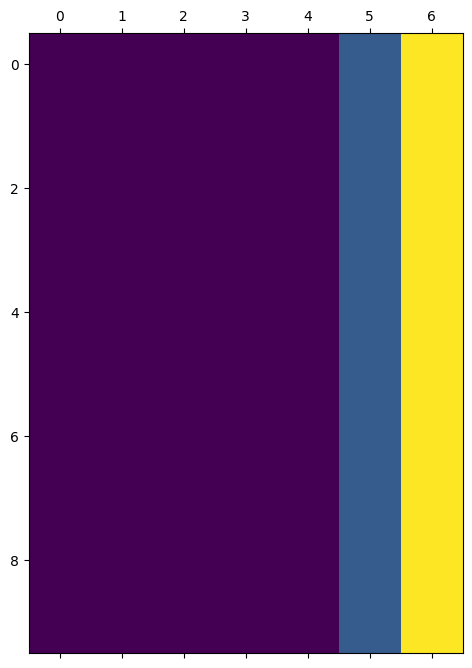

In [519]:
plt.matshow(wts[:10].numpy())

In [495]:
len(outputs),timedata(testdf, 7).__len__()

(1792, 1800)

# GRU only

In [479]:
import gru

In [500]:
model_gru = gru.train(traindataloader, params, inpdim=7)

Epoch : 0, Step: 200/318 ==> Avg Loss for epoch: 2580.87333984375
Epoch : 1, Step: 200/318 ==> Avg Loss for epoch: 432.287700881958
Epoch : 2, Step: 200/318 ==> Avg Loss for epoch: 36.35513767719269
Epoch : 3, Step: 200/318 ==> Avg Loss for epoch: 3.0828444916009903
Epoch : 4, Step: 200/318 ==> Avg Loss for epoch: 1.9999568620324135
Epoch : 5, Step: 200/318 ==> Avg Loss for epoch: 1.9751272827386857
Epoch : 6, Step: 200/318 ==> Avg Loss for epoch: 1.9613363930583
Epoch : 7, Step: 200/318 ==> Avg Loss for epoch: 2.0081431265175342
Epoch : 8, Step: 200/318 ==> Avg Loss for epoch: 2.010605113208294
Epoch : 9, Step: 200/318 ==> Avg Loss for epoch: 1.92042260825634


In [501]:
outputs_gru = gru.evaluate(model_gru, testdataloader)

In [493]:
len(testdf['Y0'].tolist()[:len(outputs)])

1792

# Predictions vs Gold

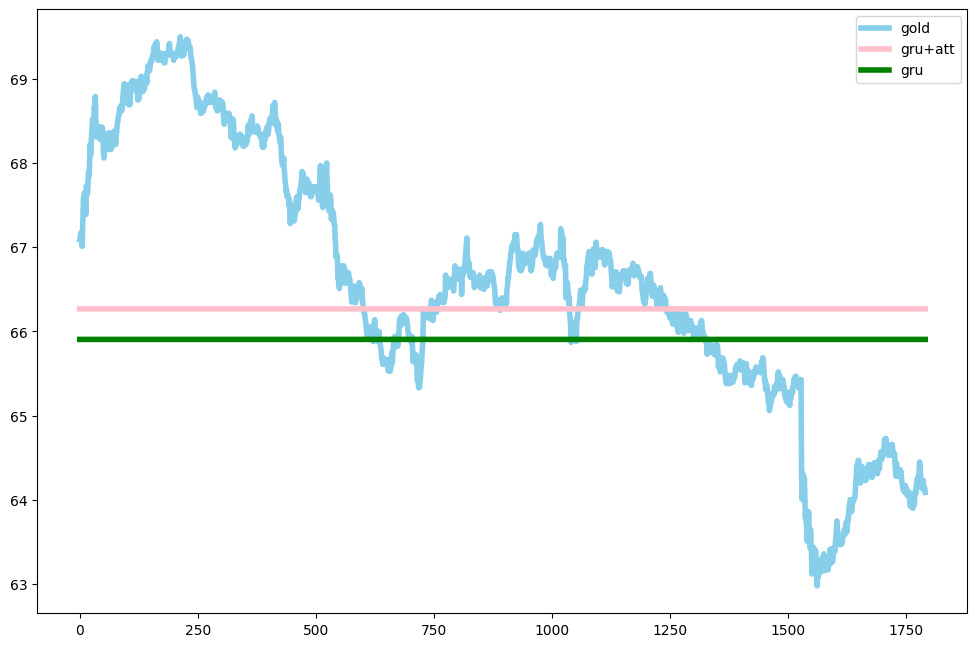

<Figure size 1000x1000 with 0 Axes>

In [520]:
# reference : https://www.python-graph-gallery.com/122-multiple-lines-chart
# https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger

# testdf['Y0'].plot(legend = False)

# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100    
    
# Data
#df=pd.DataFrame({'x_values': range(1,11), 'y1_values': np.random.randn(10), 'y2_values': np.random.randn(10)+range(1,11), 'y3_values': np.random.randn(10)+range(11,21) })
 
# multiple line plots
plt.plot(list(range(len(outputs))), testdf['Y0'].tolist()[:len(outputs)], marker=' ', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label='gold')
plt.plot( list(range(len(outputs))), outputs, marker=' ', markerfacecolor='blue', markersize=12, color='pink', linewidth=4, label='gru+att')
plt.plot( list(range(len(outputs))), outputs_gru, marker=' ', markerfacecolor='blue', markersize=12, color='green', linewidth=4, label='gru')

#plt.plot( 'x_values', 'y2_values', data=df, marker='', color='olive', linewidth=2)
#plt.plot( 'x_values', 'y3_values', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
# show legend
plt.legend()

def s(value): a = value; return (a,a) 

plt.figure(figsize=(s(10)))
# show graph
plt.show()